In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; }
.container {width:95% !important;}
</style>

<h1 style="text-align:center">Clase 11: Excitación no senoidal y excitación sísmica </h1>
<h3 style="text-align:center">ACUS262: Aislamiento y Análisis de Vibraciones</h3>
<p style="text-align:center">Dr. Víctor Poblete <br>
<a href="mailto:vpoblete@uach.cl">vpoblete@uach.cl</a><br>
<a href="https://github.com/vpobleteacustica/ACUS262-Aislamiento-y-analisis-de-vibraciones">https://github.com/vpobleteacustica/ACUS262-Aislamiento-y-analisis-de-vibraciones</a><br> 
<a href="http://www.acusticauach.cl">www.acusticauach.cl</a><br>

In [17]:
import numpy as np   
%matplotlib notebook
import matplotlib.pyplot as plt
import control 

import os
from obspy import read, read_inventory
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.util import NamedTemporaryFile
from os.path import basename
from scipy.io.wavfile import write as write_wav
import librosa as librosa
%matplotlib inline
import librosa.display
import math
import pandas as pd
import datetime



### Tarea Nº2: 

+ Se espera que los estudiantes formulen un reporte en ambiente notebook, que respalde la teoría y los códigos mediante los fundamentos de relacionados.

+ 1) Graficar la función de transmisibilidad TR.
+ 1.1) Usar distintos valores de razones de amortiguamiento $\zeta$ y graficar las curvas correspondientes. Analizar el comportamiento del TR en función de $\zeta$.
+ 1.2) Indicar en el gráfico cuál es la zona de aislación de vibraciones y explicar por qué.

+ 2) Evaluar la transmisibilidad TR y analizar cuán eficiente es un aislador para aislar vibraciones no deseadas.
+ 2.1) Suponer que la frecuencia natural de un aislador es igual a 10 Hz.
+ 2.2) Usar un factor de amortiguamiento viscoso igual a 7%.
+ 2.3) Con estos dos valores, obtener la curva de TR versus frecuencia en Hz tal como se muestra en la siguiente Figura:

<p style="text-align:center">
	<img src="TR.png" alt="MDOF" width=20%/></a><br>
    <strong> Figura 1: TR vs frecuencia en Hz.</strong>
</p>

+ 2.4) Calcular el valor de amplificación del aislador en resonancia debido al amortiguamiento de 7%.
+ 2.5) Obtener el valor de frecuencia en Hz a partir del cual el aislador comenzará a aislar la vibración no deseada.
+ 2.6) Evaluar la transmisibilidad en 30 Hz $\left({\text{TR}}_{30\,{\text{Hz}}}\right)$. Expresar este valor en %. Obtener la reducción de vibración (aislación) en 30 Hz como: $1- \left({\text{TR}}_{30\,{\text{Hz}}}\right)$. Expresar este valor en %. 
+ 2.7) Qué pasa si agregamos más amortiguamiento al asilador? Cambiar $\zeta$ a 20%. Analizar los efectos de aislación y transmisibilidad. Graficar la curva de TR versus frecuencia sobre la misma figura anterior usando otro color.
+ 2.8) Con $\zeta$ igual a 20%, calcular el valor de amplificación del aislador en resonancia.
+ 2.9) Al agregar amortiguamiento al aislador, evaluar la transmisibilidad en 30 Hz y expresarla además, en %. Obtener la reducción de vibración en 30 Hz. Expresar este valor en %.


### Excitación periódica cualquiera

+ Se usa el término excitación armónica para referirse a una excitación de tipo senoidal. O más general, una función de excitación exponencial compleja $f(t) = e^{j\omega t}$. 
+ Ahora vamos a analizar el caso de una función periódica no armónica.
+ Por definición, una función periódica es cualquier función que se repita en el tiempo. 
+ Esto es, cualquier función para la cual existe un tiempo fijo, $T$, que denominamos período.
+ El período cumple que: $f(t + T) = f(t)$.
+ De acuerdo con la teorı́a desarrollada por Fourier, cualquier función periódica $f(t)$, con periodo $T=2\pi/\omega_{0}$ , se puede representar por una serie de Fourier infinita de la forma:

$$
\begin{align*}
f(t) &= \frac{a_{0}}{2} + \sum_{n=1}^{\infty}\left( a_n\cos(n\omega_0t) + b_n\sin(n\omega_0t)\right)
\end{align*}
$$

+ Los coeficientes de Fourier se determinan de acuerdo a las siguientes fórmulas:

$$
\begin{align*}
a_0 & = \frac{\omega_0}{2\pi}\int_0^{\frac{2\pi}{\omega_0}}f(t)dt,\\
a_n & = \frac{\omega_0}{\pi}\int_0^{\frac{2\pi}{\omega_0}}f(t)\cos(n\omega_0t)dt,\\ 
b_n &= \frac{\omega_0}{\pi}\int_0^{\frac{2\pi}{\omega_0}}f(t)\sin(n\omega_0t)dt 
\end{align*}
$$

+ Usando linealidad, en un sistema vibratorio lineal la respuesta total está dada por la suma de las respuestas a los términos individuales de la serie de Fourier.

+ Vamos a comparar una función exacta con una aproximación de N términos. 

### Funciones periódicas por tramos

+ Como ejemplo, definamos una función exacta periódica que nos gustaría representar por una serie de Fourier. 
+ Veamos la Fig. 1 como una excitación por tramos. Una forma en que podemos definir funciones por tramos es usar NumPy para comparar (usando, booleano verdadero o falso) un vector de tiempo con una cierta cantidad, y luego multiplicamos el resultado booleano por la función en el rango dado.

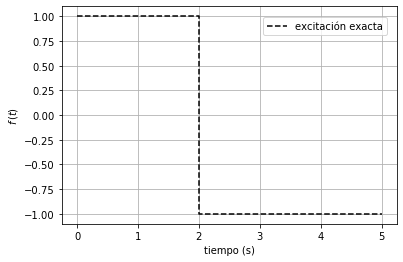

In [3]:
x = [0, 1, 2, 3, 4, 5] 
y = [1.0, 1.0, 1.0, -1.0, -1.0, -1.0]

plt.step(x, y, 'k--', label = "excitación exacta")
plt.xlabel('tiempo (s)')
plt.ylabel(r'$f\,(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor = (0.60, 0.95), loc ='upper left', borderaxespad=0.)
plt.show()

### Definiendo una función por partes 

In [4]:
# Onda cuadrada:
t = np.linspace(0, 4, 4001)           # Definimos el tiempo a observar en un período
w0 = 2.0 * np.pi / 4.0                # Definimos la frecuencia fundamental: t(end) = T)
T = 2.0 * np.pi / w0                  # Definimos el período fundamental basado en w0

y = (t > 0) - 2 * (t>2)


### Ahora, veamos su representación numérica como una serie de Fourier
+ La onda cuadrada de la Fig.1 la representaremos como 'y': 

In [5]:
num_terms = 8

a0 = w0 / (2.0 * np.pi) * np.trapz(y, t)  

a = np.zeros((num_terms,))
b = np.zeros((num_terms,))
integral_cos = np.zeros((len(t), num_terms))
integral_sin = np.zeros((len(t), num_terms))
sin_term = np.zeros((num_terms, len(t)))
cos_term = np.zeros((num_terms, len(t)))

for n in range(num_terms):

    integral_cos[:,n] = y * np.cos((n+1) * w0 * t)       
    a[n] = w0/np.pi * np.trapz(integral_cos[:,n], t)    

    integral_sin[:,n] = y * np.sin((n+1) * w0 * t)        
    b[n] = w0/np.pi * np.trapz(integral_sin[:,n], t)    
    
    sin_term[n,:] = np.sin((n+1) * w0 * t)              
    cos_term[n,:] = np.cos((n+1) * w0 * t)              

approx = np.zeros_like(t) #First fill with zeros

for ii in range(len(t)):
     approx[ii] = a0 + np.sum(a * cos_term[:,ii],0) + np.sum(b * sin_term[:,ii],0)

In [6]:
# Para observar los valores
display('El coeficiente a0 es', a0)

display('Los términos an son:')
display(np.array_str(a, precision = 4, suppress_small = True))

display('Los términos bn son:')
display(np.array_str(b, precision = 4, suppress_small = True))

'El coeficiente a0 es'

0.00012499999999998623

'Los términos an son:'

'[-0.0007  0.0002 -0.0007  0.0002 -0.0007  0.0002 -0.0007  0.0002]'

'Los términos bn son:'

'[ 1.2732  0.      0.4244  0.      0.2546  0.      0.1819  0.    ]'

### Ahora comparemos: 

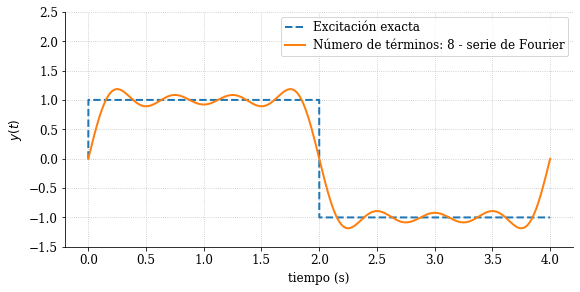

In [7]:
fig = plt.figure(figsize = (8,4))
ax = plt.gca()
plt.subplots_adjust(bottom = 0.17,left = 0.17, top = 0.96, right = 0.96)
plt.setp(ax.get_ymajorticklabels(), family = 'Serif', fontsize = 12)
plt.setp(ax.get_xmajorticklabels(), family = 'Serif', fontsize = 12)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color = '0.75')
ax.set_axisbelow(True)

plt.xlabel(r'tiempo (s)', family = 'Serif', fontsize = 12, labelpad = 5)
plt.ylabel(r'$y(t)$', family = 'Serif', fontsize = 12, labelpad = 5)

plt.plot(t, y, '--', linewidth = 2, label = r'Excitación exacta')

f = 'Número de términos: ' + str(num_terms) + ' - serie de Fourier'
plt.plot(t, approx, linewidth=2, label = f)

plt.ylim(-1.5,2.5)

leg = plt.legend(loc = 'upper right', ncol = 1, fancybox = True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize = 12)

plt.tight_layout(pad=0.5)

# Si queremos guardar la figura
f = str(num_terms) + 'orden_Serie_Fourier.pdf'
plt.savefig(f)


# Analicemos la respuesta temporal del movimiento vibratorio que transmite desde una base móvil hasta una masa

> + La excitación está en la base como se muestra en la Figura 2:

<p style="text-align:center">
	<img src="MovimientoBase.png" alt="MDOF" width=25%/></a><br>
    <strong> Figura 2: Base en vibración $y(t)$. Meirovitch, pag. 128.</strong>
</p>

> + La masa es lo que nos interesa proteger de las vibraciones.

> + La magnitud de la fuerza de excitación será $y(t)$ y en este problema, esta magnitud está dada en términos de un desplazamiento.

> + La salida o respuesta del movimiento vibratorio de la masa está dada por $x(t)$.

> + La ecuación de movimiento para el sistema es:

\begin{align*}
m\ddot{x}(t)+c\,(\dot{x}(t)-\dot{y}(t)) + k\,(x(t)-y(t))& =0
\end{align*}

\begin{align*}
\ddot{x}(t)+2\zeta \omega_{0}\,(\dot{x}(t)-\dot{y}(t))+\omega_{0}^{2}\,(x(t)-y(t))& =0
\end{align*}

\begin{align*}
\ddot{x}(t)+2\zeta \omega_{0}\,\dot{x}(t) +\omega_{0}^{2}x(t)&= 2\zeta\omega_{0}\dot{y}(t)+\omega_{0}^{2}y(t)
\end{align*}

### [Vamos a usar la librería de python: control system](https://python-control.readthedocs.io/en/0.8.3/)

In [8]:
import control

In [9]:
# Definimos  los parámetros del sistem:
m = 1.0                      # kg
k = (2.0 * np.pi)**2         # N/m 
wn = np.sqrt(k / m)          # rad/s

z = 0.25                     # razón de amortiguamiento viscoso
c = 2 * z * wn * m           # coeficiente de amortiguamiento viscoso N/(m/s)

wd = wn * np.sqrt(1 - z**2)  # frecuencia natural amortiguada (rad/s)

In [10]:
# Definimos para el análisis los coeficientes de la función de transferencia receptancia:
num = [2.0 * z * wn , wn**2]
den = [1, 2.0 * z * wn, wn**2]

# Definimos la receptancia
sys = control.tf(num, den)

# ejecutamos el análisis - primero con la función exacta 
[T_out, yout_exact, xout_exact] = control.forced_response(sys, t, y)

# ejecutamos el análisis - primero con la función aproximada 
[T_approx, yout_approx, xout_approx] = control.forced_response(sys, t, approx)

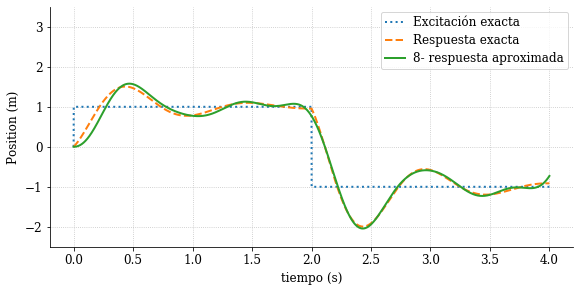

In [11]:
# Ploteamos resultados
fig = plt.figure(figsize = (8,4))
ax = plt.gca()
plt.subplots_adjust(bottom = 0.17,left = 0.17, top = 0.96, right = 0.96)
plt.setp(ax.get_ymajorticklabels(), family = 'Serif', fontsize = 12)
plt.setp(ax.get_xmajorticklabels(), family = 'Serif', fontsize = 12)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color = '0.75')
ax.set_axisbelow(True)


plt.xlabel(r'tiempo (s)', family = 'Serif', fontsize = 12, labelpad = 5)
plt.ylabel(r'Position (m)', family = 'Serif', fontsize = 12, labelpad = 5)

plt.plot(t,y,':',linewidth=2,label = r'Excitación exacta')
plt.plot(t,yout_exact,'--',linewidth = 2, label = r'Respuesta exacta')

f = str(num_terms) + '- respuesta aproximada'
plt.plot(t,yout_approx,linewidth=2,label=f)

# You may need to adjust these limits for best results
plt.ylim(-2.5, 3.5)

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='serif',fontsize=12)

plt.tight_layout(pad=0.5)

# Si queremos guardar la figura
f = str(num_terms) + 'Respuesta_temporal_aprox_Fourier.pdf'
plt.savefig(f)

#fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

In [12]:
#---------------------------------
#---------------------------------

### Excitación sísmica

+ Los terremotos han sido una de las principales causas de destrucción en todo el mundo.
+ Estos fenómenos naturales vienen con poca o ninguna advertencia.
+ [Más de 10 mil terremotos en el mundo se pueden producir en un año](https://earthquake.usgs.gov/earthquakes/browse/significant.php)
+ Un terremoto se caracteriza por temblores del suelo debido a la liberación repentina de energía en las capas terrestres. 
+ Estas ondas de movimiento del suelo se pueden registrar y estudiar luego.
+ Si podemos predecir terremotos con unos minutos de anticipación y enviar alertas, podríamos salvar muchas vidas y mitigar los daños de los terremotos. 
+ Unos minutos de advertencia permitirían que las personas tomaran precauciones tales como llegar a un lugar seguro, ponerse a cubierto o desconectar la electricidad.

### Cómo se registra:
+ La excitación sísmica se registra por un instrumento conocido como sismógrafo. 
+ Un sismógrafo consiste en una masa pesada unida a una base fija [ver](https://earthquake.usgs.gov/learn/glossary/?term=seismograph).
+ Un sismograma es un registro del movimiento del suelo en función del tiempo. 
+ Los sismogramas se registra usando tres direcciones: BHZ, BHN y BHE. 
+ El canal BHZ indica que la señal fue registrado perpendicular a la superficie de la Tierra.
+ BHN está a lo largo del eje Y 
+ BHE está a lo largo del eje X. 


### Ondas sísmicas p y s:

+ Hay dos tipos de ondas sísmicas características: ondas p y ondas s. 
+ La onda p también se conoce como onda compresional o longitudinal, u onda primaria.
+ El movimiento de la onda p es similar al de las ondas de sonido.
+ La onda p empuja y tira las rocas por las que viaja, en la dirección de propagación.
+ La onda p puede viajar a través sólidos y líquidos.
+ La onda s (secundaria) es una onda en la que el desplazamiento es transversal a la dirección de propagación. Su velocidad es menor que la de la onda p.
+ La onda s sólo viaja a través de sólidos.
+ La onda s es más destructiva que la onda p.
+ A medida que las ondas sísmicas viajan a través del volumen de la tierra alejándose del epicentro del terremoto, la distancia entre la onda p y la onda s aumenta. 
+ Esta diferencia de tiempo entre la onda p y s es el tiempo de alerta que se le puede dar a los ciudadanos.


### Encontrar datos sísmicos:
+ El conjunto de datos sismológicos clásico consiste en registros de formas de onda para un determinado terremoto.
+ [IRIS](https://www.iris.edu/hq/about_iris) es un consorcio de más de 100 universidades norteamericanas dedicadas a la operación de instalaciones científicas para la adquisición, gestión y distribución de datos sismológicos. 
+ Los programas IRIS contribuyen a la investigación académica, la educación, la mitigación del peligro de terremotos y la verificación del Tratado de Prohibición Completa de los Ensayos Nucleares.
+ Podemos encontrar datos actualizados de eventos sísmicos, en particular de [Chile:](https://ds.iris.edu/latin_am/evlist.phtml?region=chile).
+ La información de los eventos sísmicos muestra la fecha y hora del momento en que el terremoto occurrió. 
+ La hora es expresada en Tiempo Universal Coordinado - UTC (Coordinated Universal Time en inglés), que también muy a menudo es referido a la hora en Meridiano de Greenwich, o en la longitud de 0 grados, aproximadamente seis horas adelantadas de Perú y Ecuador y a siete horas de Costa Rica.
+ La hora del día es generalmente expresada en el sistema de 24 horas. Cada hora tiene un número diferente, entonces no se necesitan indicadores AM o PM.
+ Por ejemplo, 17:45 es 5:45 PM.  
+ Adicionalmente, el formato para el reloj de 24 horas es: Horas:Minutos:Segundos. 
+ Por ejemplo, 02:00:05 es 2:00 AM y 5 segundos.
+ Otro característica es que el mundo se divida en 24 zonas, cada una con su propia hora local. 


### Librería Obspy
+ [Obspy](https://www.geophysik.uni-muenchen.de/~megies/www_obsrise/) es una librería de Python de código abierto para manipular y derivar resultados de datos sísmicos.
+ En GitHub se puede encontrar el [repositorio original](https://github.com/obspy/obspy).
+ Obspy se puede utilizar para leer o escribir archivos sísmicos en varios formatos, por ejemplo, .sac (Seismic Analysis Code).
+ Descargar un archivo de datos sísmicos [desde The EarthScope Automated Receiver Survey (EARS)](http://ears.iris.washington.edu/networkList.html), luego ir a [Red Sismológica Nacional](http://ears.iris.washington.edu/stationList.html?netCode=C1&gaussian=2.5): 

### Descargar y plotear una traza sísmica:

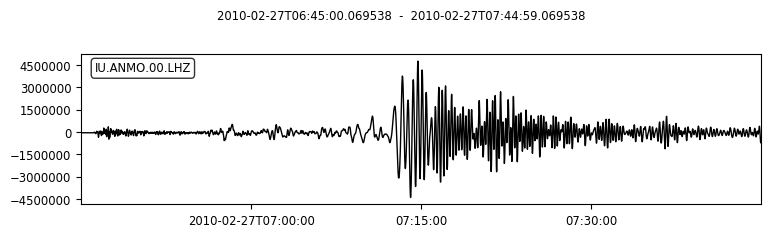

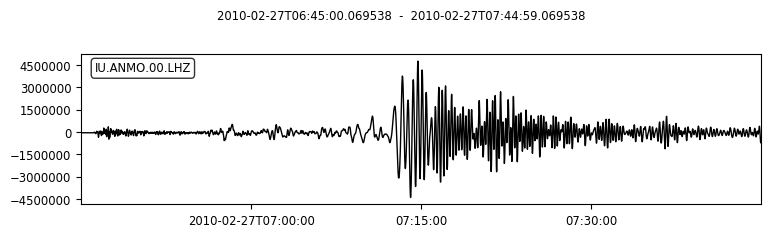

In [20]:
# https://docs.obspy.org/packages/obspy.clients.fdsn.html 
client = Client("IRIS")
t = UTCDateTime("2010-02-27T06:45:00.000")
st = client.get_waveforms("IU", "ANMO", "00", "LHZ", t, t + 60 * 60)
st.plot() 



In [13]:
st = read('2020_270_17_10_22.itt', debug_headers=True)
display(st[0].stats) 



         network: C1
         station: LR04
        location: 
         channel: ITT
       starttime: 2020-09-26T17:21:24.060000Z
         endtime: 2020-09-26T17:24:07.860000Z
   sampling_rate: 25.0
           delta: 0.04
            npts: 4096
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.039999999, 'depmin': -0.23371512, 'depmax': 0.12492272, 'scale': -12345.0, 'odelta': -12345.0, 'b': 661.487, 'e': 163.8, 'o': 0.0, 'a': 671.487, 'internal0': -12345.0, 't0': -12345.0, 't1': -12345.0, 't2': -12345.0, 't3': -12345.0, 't4': -12345.0, 't5': -12345.0, 't6': -12345.0, 't7': -12345.0, 't8': -12345.0, 't9': -12345.0, 'f': -12345.0, 'resp0': -12345.0, 'resp1': -12345.0, 'resp2': -12345.0, 'resp3': -12345.0, 'resp4': -12345.0, 'resp5': -12345.0, 'resp6': -12345.0, 'resp7': -12345.0, 'resp8': -12345.0, 'resp9': -12345.0, 'stla': -39.880192, 'stlo': -73.425819, 'stel': 93.599998, 'stdp': 2.5, 'evla': -48.063499, 'evlo': 31.6744, 'evel': 0.0, 'evdp': 10000.

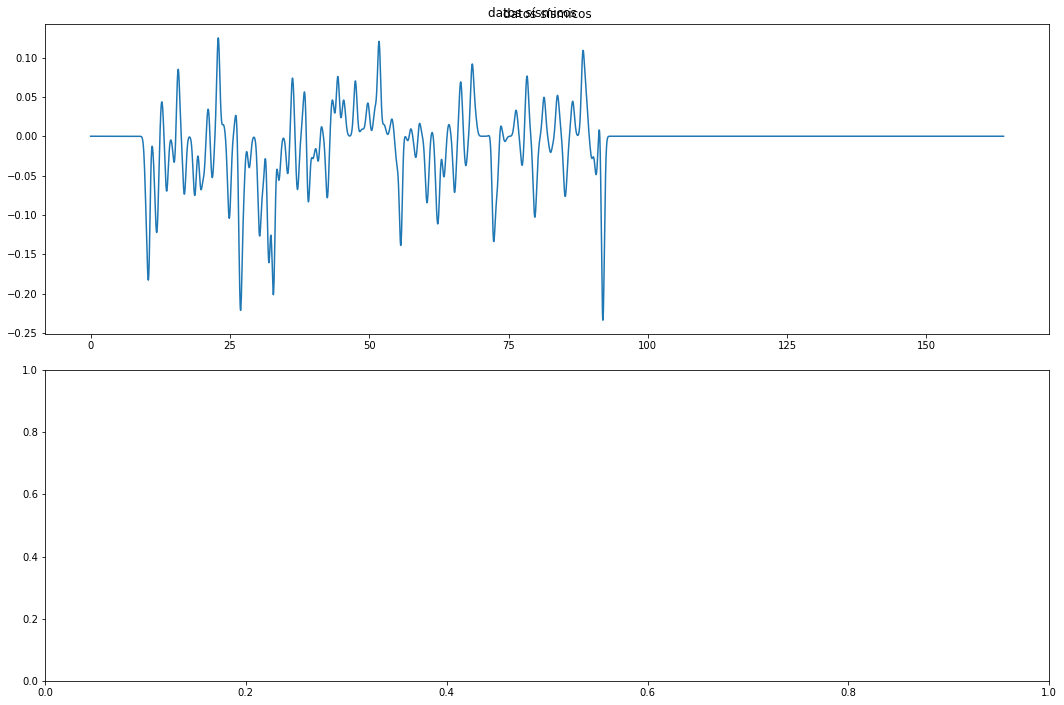

In [14]:
tr = st[0]
samples = tr.data
sr = 25.0
L = len(samples)                             # némero total de muestras
t = np.linspace(0, L/sr, L) 

fig, axs = plt.subplots(2, figsize=(15, 10))
fig.suptitle('datos sísmicos')
axs[0].plot(t, samples)
axs[0].set_title('datos sísmicos')
fig.tight_layout(pad = 1.5)